### importing the required libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [17]:
def ajay(Z):
    aja=1/(1+np.exp(-Z))
    return aja

### cost function

In [18]:
def costf(X,y,theta,type):
    ypre=X.dot(theta.T)
    if type=='lin':
        sqr_error=(ypre-y)**2
        sumofsquares=np.sum(sqr_error)
        return (1/2*X.shape[0])*sumofsquares
    elif type=='aja':
        term1=-y*(np.log(ajay(ypre)))
        term2=-(1-y)*np.log(1-ajay(ypre))
        return (1/X.shape[0])*np.sum(term1+term2)

### gradient descent

In [19]:
def gradient(X,y,theta,cycle,alpha,type):
    cost = np.zeros(cycle)
    for i in range(cycle):
        if type=='lin':
            error=((X.dot(theta.T))-y)
        elif type=='aja':
            error=(ajay(X@theta.T)-y)
        multiplyerror = (error.T@X)
        theta = theta-(alpha/X.shape[1])*multiplyerror
        cost[i] = costf(X, y, theta,type)
    return theta,cost

### normalisation

In [20]:
def normal(mat):
    factor1=mat.min()
    factor2=mat.max()-mat.min()
    matrix_nor = (mat-factor1)/factor2
    return matrix_nor,factor1,factor2

### concate

In [21]:
def concate(mat):
    mat=np.concatenate((np.ones((mat.shape[0],1)),mat), axis=1)
    return mat

### prediction and r2 score

In [22]:
def r2s(Ypr, y):
    rss = np.sum((Ypr - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)
    r2 = 1 - (rss / tss)
    return r2

def Predict(X,theta,type):
    if type=='lin':
        Ypr=X.dot(theta.T)
    elif type=='aja':
        Ypr=X.dot(theta.T)
        for i in range(Ypr.shape[0]):
         if Ypr[i,0]<0:
            Ypr[i,0]=0
         elif Ypr[i,0]>0:
            Ypr[i,0]=1
    return Ypr

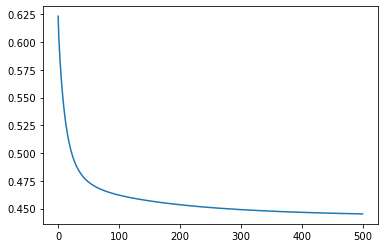

[0.96650718]
[[0.]] [[1.]]


In [23]:
def fill_age(url, type, dataset):
    if dataset=='train':
        labels=['Survived','Pclass','Sex','Age','SibSp','Parch','Fare']
        col=3
    elif dataset=='test':
        labels=['Pclass','Sex','Age','SibSp','Parch','Fare']
        col=2
    data=pd.read_csv(url, skipinitialspace=True, usecols=labels)
    data['Sex'].replace(['male','female'],[1,0],inplace=True)
    if type=='median':
        data['Age']=data['Age'].fillna(data['Age'].median())
    elif type=='interpolate':
        data['Age']=data['Age'].interpolate()
    elif type=='multivariate':
        cycle=1000000
        dep_data=data.dropna(axis=0)
        dep_data_reg=dep_data.loc[:,['Pclass','Sex','SibSp','Parch','Fare']].values
        dep_data_age=dep_data.loc[:,['Age']].values
        theta=np.zeros((1,dep_data_reg.shape[1]+1))
        data_reg_nor,fac1,fac2=normal(dep_data_reg)
        data_reg_nor=concate(data_reg_nor)
        theta1, cost=gradient(data_reg_nor,dep_data_age,theta,cycle,0.01,'lin')
        age_predict=Predict(data_reg_nor,theta1,'lin')
        r2_score=r2s(age_predict,dep_data_age)
        
        print('r2 ', r2_score)
        for i in range(data.shape[0]):
            if math.isnan(data.iloc[i,col]):
                data_dep=data.loc[i:i+1,['Pclass','Sex','SibSp','Parch','Fare']].values
                data_dep=(data_dep-fac1)/fac2
                data_dep=concate(data_dep)
                data.iloc[i,col]=Predict(data_dep,theta1,'lin')[0,0]
    
    return data


train_data=fill_age("file:///home/mas/Downloads/train.csv",'median','train')
data_cat=train_data.loc[:,['Pclass','Sex','Age','SibSp','Parch','Fare']]
data_survive=train_data.loc[:,['Survived']]
theta=np.array([[0,0,0,0,0,0,0]])
data_cat,fac1,fac2=normal(data_cat)
data_cat=concate(data_cat)
theta,cost=gradient(data_cat,data_survive,theta,500,0.01,'aja')
survive_predict=Predict(data_cat,theta,'aja')
plt.plot(range(500),cost)
plt.show()

test_data=fill_age("file:///home/mas/Downloads/test.csv",'median','test')
test_cat=test_data.loc[:,['Pclass','Sex','Age','SibSp','Parch','Fare']].values
test_cat=(test_cat-np.array(fac1))/np.array(fac2)
test_cat=concate(test_cat)
test_predict=Predict(test_cat,theta,'aja')

df=pd.read_csv("file:///home/mas/Downloads/gender_submission.csv",skipinitialspace=True, usecols=['Survived']).values
print(sum(test_predict==df)/len(df))

query_arpit=concate((np.array([[3,1,20,0,0,7.5]])-np.array(fac1))/np.array(fac2))
query_shreya=concate((np.array([[1,0,19,1,1,512]])-np.array(fac1))/np.array(fac2))
qa=Predict(query_arpit,theta,'aja')
qs=Predict(query_shreya,theta,'aja')
print(qa,qs)